# DATA EXP

In [7]:
import matplotlib.pyplot as plt
import numpy as np
import os
from multiprocessing.dummy import Pool as ThreadPool

In [2]:
def readHCL(filename):
  X=[]
  with open(filename, "rb") as f:
    #meta = f.read(512) # read first block, it is meta data
    sx = f.read(512)
    s= np.zeros((64,64))
    while sx:
        # Do stuff with byte.
        for i in range(64):
            for k in range(8):
                dat=sx[i*8+k]
                for j in reversed(range(8)):
                    s[i][k*8+7-j]=(dat >> j)&0x01
        X.append(np.copy(s))
        sx = f.read(512)
    return X

In [ ]:
#filename="OCR/ch0001.hcl"
#pool=ThreadPool(1000)
#X=[]
#path='OCR'
#for fn in sorted(os.listdir(path)):
#    if fn.endswith('hcl') and "xx00" in fn:
#        X+= readHCL("{}/{}".format(path,fn))
#pool.map(readHCL,["{}/{}".format(path,fn) for fn in os.listdir(path) if fn.endswith('hcl') and "xx" in fn])
#pool.close()
#pool.join()

In [3]:
filename="OCR/test/hh001.hcl"
d=readHCL(filename)

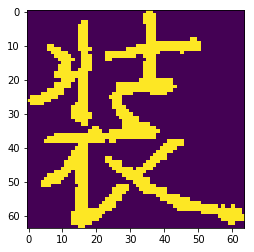

In [4]:
plt.imshow(d[3682])

## HCL loader sequnce generator:

In [5]:
import numpy as np
import os
from keras import backend as K
from keras.utils import Sequence, to_categorical

# Here, `x_set` is list of path to the images
# and `y_set` are the associated classes.

class HCLSequence(Sequence):
    CHAR_PER_FILE = 3755 # hh and xx files
    #CHAR_PER_FILE = 1000 # ch files

    def __init__(self, file_path, batch_size):
        self.file_list=[x for x in sorted(os.listdir(file_path))]
        self.batch_size = batch_size
        self.path = file_path

    def __len__(self):
        return int(np.ceil(len(self.file_list)*self.CHAR_PER_FILE / float(self.batch_size)))

    def read_at_offset(self,filename,offset, read_count):
        X=[]
        file_to_open= "{}/{}".format(self.path,filename)
        with open(file_to_open, "rb") as f:
            meta = f.read(512) # read first block, it is meta data
            s= np.zeros((64,64))
            f.seek(512*(offset+1))
            for c in range(read_count):
                sx = f.read(512)
                # Do stuff with byte.
                for i in range(64):
                    for k in range(8):
                        dat=sx[i*8+k]
                        for j in reversed(range(8)):
                            s[i][k*8+7-j]=(dat >> j)&0x01
                X.append(np.copy(s))
        return X
    def __getitem__(self, idx):
        X=[]
        offset=(idx*self.batch_size) % self.CHAR_PER_FILE
        fid=idx*self.batch_size//self.CHAR_PER_FILE
        #print(offset,fid, self.file_list[fid])

        if self.CHAR_PER_FILE - offset < self.batch_size: #need read next file 
            X+=self.read_at_offset(self.file_list[fid], offset, self.CHAR_PER_FILE - offset ) # read till the end

            X+=self.read_at_offset(self.file_list[(fid+1)%len(self.file_list)], 0, self.batch_size-self.CHAR_PER_FILE + offset) # read the left char from next file
        else:
            X+=self.read_at_offset(self.file_list[fid], offset, self.batch_size)
        X_raw=np.array(X)
        y_raw=np.array([(offset+idx)%self.CHAR_PER_FILE for idx in range(self.batch_size)])
        if K.image_data_format() == 'channels_first':
            X_raw = X_raw.reshape(X_raw.shape[0], 1, 64, 64)
        else:
            X_raw = X_raw.reshape(X_raw.shape[0], 64, 64, 1)
        return X_raw,to_categorical(y_raw,self.CHAR_PER_FILE)

Using TensorFlow backend.


# Start Training

In [8]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras.losses import categorical_crossentropy
from keras.optimizers import Adadelta
from keras.utils import multi_gpu_model
from hcl_gen import HCLSequence
from keras import backend as K
import tensorflow as tf
import json
from keras.callbacks import ModelCheckpoint, EarlyStopping

# Basic model info / hyperparams
batch_size = 512
num_category = 3755
epochs = 12

# input image dimensions

img_rows, img_cols = 64, 64
if K.image_data_format() == 'channels_first':
    input_shape = (1, img_rows, img_cols)
else:
    input_shape = (img_rows, img_cols, 1)
        
myGenTrain=HCLSequence('OCR/train', batch_size) # 700
myGenTest= HCLSequence('OCR/test', batch_size,734) # 300 

## callbacks: 1. early stopping, 2. save best
callbacks = [
    EarlyStopping(
        monitor='val_acc', 
        patience=10,
        mode='max',
        verbose=1),
    ModelCheckpoint("checkpoint.{epoch:02d}.hdf5",
        monitor='val_acc', 
        save_best_only=True, 
        mode='max',
        verbose=0)
]


##model building
with tf.device('/cpu:0'):
    model = Sequential()
#convolutional layer with rectified linear unit activation
model.add(Conv2D(32, kernel_size=(3, 3),
                 activation='relu',
                 input_shape=input_shape))
#32 convolution filters used each of size 3x3
#again
model.add(Conv2D(64, (3, 3), activation='relu'))
#64 convolution filters used each of size 3x3
#choose the best features via pooling
model.add(MaxPooling2D(pool_size=(2, 2)))
#randomly turn neurons on and off to improve convergence
model.add(Dropout(0.25))
#flatten since too many dimensions, we only want a classification output
model.add(Flatten())
#fully connected to get all relevant data
model.add(Dense(128, activation='relu'))
#one more dropout for convergence' sake :) 
model.add(Dropout(0.5))
#output a softmax to squash the matrix into output probabilities
model.add(Dense(num_category, activation='softmax'))
## generate multi_gpu_model from base template
parallel_model = multi_gpu_model(model,gpus=2)
parallel_model.compile(loss=categorical_crossentropy,
              optimizer=Adadelta(),
              metrics=['accuracy'])
hist=parallel_model.fit_generator(myGenTrain,  epochs=epochs, verbose=1,  validation_data=myGenTest, max_queue_size=10, workers=8, use_multiprocessing=True, shuffle=True, initial_epoch=0, callbacks=callbacks)
## evaluate and generate score:
score=parallel_model.evaluate_generator(myGenTest, 10, workers=10, use_multiprocessing=True, verbose=1)
print('Test score:', score[0])
print('Test accuracy:', score[1])
model.save("ocr_model_ep{}_ba{}.h5".format(epochs,batch_size))
with open("ocr_hist_ep{}_ba{}.json".format(epochs,batch_size), 'w') as f:
    json.dump(hist.history, f)

AttributeError: 'HCLSequence' object has no attribute 'shape'

In [5]:
from hcl_gen import HCLSequence
batch_size = 128

myGenTrain=HCLSequence('OCR/train', batch_size) # 700
myGenTest= HCLSequence('OCR/test', batch_size) # 300 

X,y=myGenTrain.__getitem__(30)

In [4]:
X.shape

(128, 64, 64, 1)

In [9]:
import keras

model.compile(loss=categorical_crossentropy,
              optimizer=Adadelta(),
              metrics=['accuracy'])

In [ ]:
import keras
from keras.utils import multi_gpu_model

parallel_model = multi_gpu_model(model,gpus=2)
parallel_model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=keras.optimizers.Adadelta(),
              metrics=['accuracy'])
parallel_model.fit_generator(myGenTrain,  epochs=epochs, verbose=1,  validation_data=myGenTest, max_queue_size=10, workers=4, use_multiprocessing=True, shuffle=True, initial_epoch=0)


In [10]:
#some say it should be rolled back by 2 layers to save
from keras.models import load_model 
saved_model_dir="savedModel"
save_model = parallel_model.layers[-2] 
save_model.save(saved_model_dir+'v1.h5') # creates a HDF5 file 'my_model.h5'

In [20]:
score=parallel_model.evaluate_generator(myGenTest,steps=1000, workers=10, use_multiprocessing=True, verbose=0)


0 0 hh001.hcl
384 0 hh001.hcl
256 0 hh001.hcl
640 0 hh001.hcl
512 0 hh001.hcl
128 0 hh001.hcl
768 0 hh001.hcl
896 0 hh001.hcl
1024 0 hh001.hcl
1152 0 hh001.hcl
1280 0 hh001.hcl
1408 0 hh001.hcl
1536 0 hh001.hcl
1664 0 hh001.hcl
1792 0 hh001.hcl
1920 0 hh001.hcl
2048 0 hh001.hcl
2176 0 hh001.hcl
2304 0 hh001.hcl
2432 0 hh001.hcl
2560 0 hh001.hcl
2688 0 hh001.hcl
2816 0 hh001.hcl
2944 0 hh001.hcl
3072 0 hh001.hcl
3200 0 hh001.hcl
3328 0 hh001.hcl
3456 0 hh001.hcl
3584 0 hh001.hcl
3712 0 hh001.hcl
85 1 hh002.hcl
213 1 hh002.hcl
341 1 hh002.hcl
469 1 hh002.hcl
597 1 hh002.hcl
725 1 hh002.hcl
853 1 hh002.hcl
981 1 hh002.hcl
1109 1 hh002.hcl
1237 1 hh002.hcl
1365 1 hh002.hcl
1493 1 hh002.hcl
1621 1 hh002.hcl
1749 1 hh002.hcl
1877 1 hh002.hcl
2005 1 hh002.hcl
2133 1 hh002.hcl
2261 1 hh002.hcl
2389 1 hh002.hcl
2517 1 hh002.hcl
2645 1 hh002.hcl
2773 1 hh002.hcl
2901 1 hh002.hcl
3029 1 hh002.hcl
3157 1 hh002.hcl
3285 1 hh002.hcl
3413 1 hh002.hcl
3541 1 hh002.hcl
3669 1 hh002.hcl
42 2 hh003.hcl
1

1360 16 hh017.hcl
1488 16 hh017.hcl
1616 16 hh017.hcl
1744 16 hh017.hcl
1872 16 hh017.hcl
2000 16 hh017.hcl
2128 16 hh017.hcl
2256 16 hh017.hcl
2384 16 hh017.hcl
2512 16 hh017.hcl
2640 16 hh017.hcl
2768 16 hh017.hcl
2896 16 hh017.hcl
3024 16 hh017.hcl
3152 16 hh017.hcl
3280 16 hh017.hcl
3408 16 hh017.hcl
3536 16 hh017.hcl
3664 16 hh017.hcl
37 17 hh018.hcl
165 17 hh018.hcl
293 17 hh018.hcl
421 17 hh018.hcl
549 17 hh018.hcl
677 17 hh018.hcl
805 17 hh018.hcl
933 17 hh018.hcl
1061 17 hh018.hcl
1189 17 hh018.hcl
1317 17 hh018.hcl
1445 17 hh018.hcl
1573 17 hh018.hcl
1701 17 hh018.hcl
1829 17 hh018.hcl
1957 17 hh018.hcl
2085 17 hh018.hcl
2213 17 hh018.hcl
2341 17 hh018.hcl
2469 17 hh018.hcl
2597 17 hh018.hcl
2725 17 hh018.hcl
2853 17 hh018.hcl
2981 17 hh018.hcl
3109 17 hh018.hcl
3237 17 hh018.hcl
3365 17 hh018.hcl
3493 17 hh018.hcl
3621 17 hh018.hcl
3749 17 hh018.hcl
122 18 hh019.hcl
250 18 hh019.hcl
378 18 hh019.hcl
506 18 hh019.hcl
634 18 hh019.hcl
762 18 hh019.hcl
890 18 hh019.hcl
1018 18 

544 32 hh033.hcl
672 32 hh033.hcl
800 32 hh033.hcl
928 32 hh033.hcl
1056 32 hh033.hcl
1184 32 hh033.hcl
1312 32 hh033.hcl
1440 32 hh033.hcl
1568 32 hh033.hcl
1696 32 hh033.hcl
1824 32 hh033.hcl
1952 32 hh033.hcl
2080 32 hh033.hcl
2208 32 hh033.hcl
2336 32 hh033.hcl
2464 32 hh033.hcl
2592 32 hh033.hcl
2720 32 hh033.hcl
2848 32 hh033.hcl
2976 32 hh033.hcl
3104 32 hh033.hcl
3232 32 hh033.hcl
3360 32 hh033.hcl
3488 32 hh033.hcl
3616 32 hh033.hcl
3744 32 hh033.hcl
117 33 hh034.hcl
245 33 hh034.hcl
373 33 hh034.hcl
501 33 hh034.hcl
629 33 hh034.hcl
757 33 hh034.hcl
885 33 hh034.hcl
1013 33 hh034.hcl
1141 33 hh034.hcl
1269 33 hh034.hcl
1397 33 hh034.hcl
1525 33 hh034.hcl
1653 33 hh034.hcl
1781 33 hh034.hcl
1909 33 hh034.hcl
2037 33 hh034.hcl
2165 33 hh034.hcl
2293 33 hh034.hcl
2421 33 hh034.hcl
2549 33 hh034.hcl
2677 33 hh034.hcl
2805 33 hh034.hcl
2933 33 hh034.hcl
3061 33 hh034.hcl
3189 33 hh034.hcl
3317 33 hh034.hcl
3445 33 hh034.hcl
3573 33 hh034.hcl
3701 33 hh034.hcl
74 34 hh035.hcl
202 3

In [22]:
# ------------ save the template model rather than the gpu_mode ----------------
# serialize model to JSON
model_json = model.to_json()
with open("model.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model.save_weights("model_weights.h5")
print("Saved model to disk")

Saved model to disk


In [17]:
print('Test score:', score[0])
print('Test accuracy:', score[1])

Test score: 0.9446132672652602
Test accuracy: 0.805453125


In [18]:
model.save("model_v1.h5")

In [21]:
model.save_weights("weights_v1.h5")

In [ ]:
print('Test score:', score[0])
print('Test accuracy:', score[1])

In [3]:
score

[0.5792870923839509, 0.877109375]

In [9]:
comp=dict(epoc20_batch128_base=score)

In [10]:
comp.update(epoc12_batch256_base=[0.36245066531188785, 0.919234375])

{'epoc12_batch256_base': [0.36245066531188785, 0.919234375],
 'epoc20_batch128_base': [0.5792870923839509, 0.877109375]}